## Import Packages

In [1]:
from data import shortestpath, dataset
from model import shortestPathModel
from func import SPOPlus
from evalm import unambSPO

In [2]:
import time
import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.utils.data import DataLoader

## Build Model 

In [3]:
# model for shortest path
grid = (5,5)
sp_model = shortestPathModel(grid)

Academic license - for non-commercial use only - expires 2021-06-13
Using license file C:\Users\Apocrypse\gurobi.lic


## Training

In [4]:
# build linear model
class LinearRegression(nn.Module):
    
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(p, (grid[0] - 1) * grid[1] + (grid[1] - 1) * grid[0])
    
    def forward(self, x):
        out = self.linear(x)
        return out

In [5]:
def train(dataloader, opt_model, num_epochs, learning_rate, l1_lambda=1e-3):
    """
    train model with SPO+ Loss
    args:
      dataloader: dataloader from optDataSet
      model: optModel
      num_epochs: number of epochs
      l2_lambda: l2 regularization parameter
    """
    print('Training...')
    # init model
    lr = LinearRegression()
    # cuda
    if torch.cuda.is_available():
        lr = lr.cuda()
    # training mode
    lr.train()
    # set optimizer
    optimizer = torch.optim.Adam(lr.parameters(), lr=learning_rate)
    # set SPO+ Loss as criterion
    criterion = SPOPlus()
    # train
    time.sleep(1)
    for epoch in tqdm(range(num_epochs)):
        # load data
        for i, data in enumerate(dataloader):
            x, c, w, z = data
            # cuda
            if torch.cuda.is_available():
                x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
            # forward pass
            cp = lr(x)
            loss = criterion.apply(opt_model, cp, c, w, z).mean()
            # l1 reg
            l1_reg = torch.abs(cp - c).sum(dim=1).mean()
            loss += l1_lambda * l1_reg
            # learning rate decay
            cur_lr = learning_rate * 0.6 ** math.floor((epoch / num_epochs) * 10)
            for param_group in optimizer.param_groups:
                param_group['lr'] = cur_lr
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return lr

## Experiments

### Training Set Size = 100, Noise Half−width = 0

In [6]:
# set up
n = 100 # number of data
p = 5 # size of feature
e = 0 # noise half−width
degs = [1, 2, 4, 6] # list of param deg

In [7]:
# init DataFrame
df1 = pd.DataFrame(columns = degs)

In [8]:
for i in range(8):
    row = {}
    for deg in degs:
        # generate data
        x, c = shortestpath.genData(n+1000, p, grid, deg=deg, noise_width=e, seed=i)
        # data split
        x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=i)
        # build data set
        sp_dataset_train = dataset.optDataset(sp_model, x_train, c_train)
        sp_dataset_test = dataset.optDataset(sp_model, x_test, c_test)
        # get data loader
        batch_size = 32
        sp_loader_train = DataLoader(sp_dataset_train, batch_size=batch_size, shuffle=True)
        sp_loader_test = DataLoader(sp_dataset_test, batch_size=batch_size, shuffle=False)
        # train
        learning_rate = 1e-3 * (3 ** deg + 1)
        num_epochs = 500 * deg
        lr = train(sp_loader_train, sp_model, num_epochs=num_epochs, learning_rate=learning_rate, l1_lambda=1e-3)
        # eval
        loss = unambSPO(lr, sp_model, sp_loader_test)
        print('Normalized SPO Loss: {:.2f}%'.format(loss * 100))
        row[deg] = loss
        print()
    df1 = df1.append(row, ignore_index = True)

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 324.48it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.59it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:35<00:00,  3.22it/s]


Normalized SPO Loss: 0.43%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 412.03it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 409.62it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [05:22<00:00,  3.10it/s]


Normalized SPO Loss: 0.11%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 329.60it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 308.33it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 2000/2000 [10:29<00:00,  3.18it/s]


Normalized SPO Loss: 1.32%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 447.62it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 414.97it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 3000/3000 [14:57<00:00,  3.34it/s]


Normalized SPO Loss: 5.06%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 361.98it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 375.64it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:34<00:00,  3.23it/s]


Normalized SPO Loss: 0.38%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 349.96it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 363.70it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [05:05<00:00,  3.27it/s]


Normalized SPO Loss: 0.14%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 286.92it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 310.32it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 2000/2000 [10:04<00:00,  3.31it/s]


Normalized SPO Loss: 1.46%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 407.57it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 352.66it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 3000/3000 [17:15<00:00,  2.90it/s]


Normalized SPO Loss: 5.66%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 269.54it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 261.58it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [03:05<00:00,  2.69it/s]


Normalized SPO Loss: 0.51%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 282.14it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 322.37it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [05:30<00:00,  3.03it/s]


Normalized SPO Loss: 0.17%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 364.64it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 418.39it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 2000/2000 [10:26<00:00,  3.19it/s]


Normalized SPO Loss: 1.73%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 257.43it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 293.70it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 3000/3000 [15:31<00:00,  3.22it/s]


Normalized SPO Loss: 6.04%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 349.96it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 369.92it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:34<00:00,  3.23it/s]


Normalized SPO Loss: 0.37%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 398.65it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 355.29it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [05:04<00:00,  3.28it/s]


Normalized SPO Loss: 0.25%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 313.78it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.36it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 2000/2000 [10:10<00:00,  3.27it/s]


Normalized SPO Loss: 2.26%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 470.62it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 372.45it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 3000/3000 [15:15<00:00,  3.28it/s]


Normalized SPO Loss: 6.82%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 367.29it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 304.25it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:34<00:00,  3.23it/s]


Normalized SPO Loss: 0.29%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 387.11it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 340.05it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [05:14<00:00,  3.18it/s]


Normalized SPO Loss: 0.14%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 299.98it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 301.97it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 2000/2000 [08:50<00:00,  3.77it/s]


Normalized SPO Loss: 1.55%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 437.85it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 472.07it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 3000/3000 [12:51<00:00,  3.89it/s]


Normalized SPO Loss: 4.26%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 424.01it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 435.11it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:13<00:00,  3.75it/s]


Normalized SPO Loss: 1.01%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 351.81it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 372.69it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:35<00:00,  3.62it/s]


Normalized SPO Loss: 0.36%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 428.43it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 360.70it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 2000/2000 [09:24<00:00,  3.54it/s]


Normalized SPO Loss: 2.50%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 393.20it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 408.40it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 3000/3000 [13:40<00:00,  3.66it/s]


Normalized SPO Loss: 8.26%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 335.81it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 424.83it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:10<00:00,  3.82it/s]


Normalized SPO Loss: 0.41%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 486.58it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 431.52it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [05:04<00:00,  3.28it/s]


Normalized SPO Loss: 0.10%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 354.96it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 342.75it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 2000/2000 [09:02<00:00,  3.69it/s]


Normalized SPO Loss: 0.93%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 447.56it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 457.14it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 3000/3000 [12:36<00:00,  3.96it/s]


Normalized SPO Loss: 3.14%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 426.45it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 455.06it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:07<00:00,  3.94it/s]


Normalized SPO Loss: 0.33%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 441.64it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 467.75it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:16<00:00,  3.90it/s]


Normalized SPO Loss: 0.18%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 437.85it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 451.75it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 2000/2000 [08:22<00:00,  3.98it/s]


Normalized SPO Loss: 1.24%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 438.79it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 455.94it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 3000/3000 [12:51<00:00,  3.89it/s]


Normalized SPO Loss: 3.36%



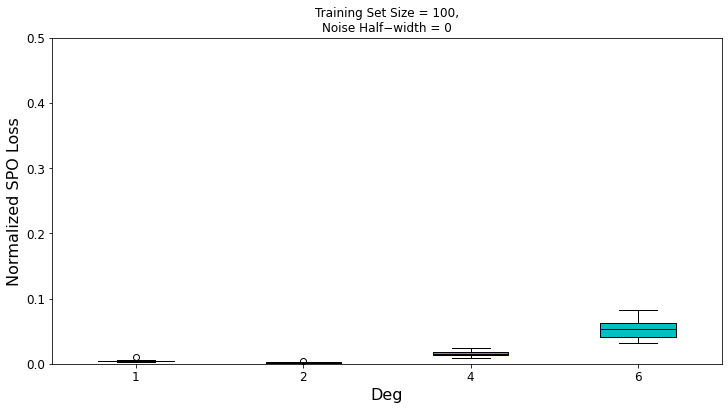

In [9]:
# draw boxplot
plt.figure(figsize=(12,6))
plt.boxplot(df1, boxprops=dict(facecolor='c', color='k'), medianprops=dict(color='k'), patch_artist=True)
plt.xlabel('Deg', fontsize=16)
plt.xticks(ticks=[1,2,3,4], labels=[1,2,4,6], fontsize=12)
plt.ylabel('Normalized SPO Loss', fontsize=16)
plt.yticks(fontsize=12)
plt.ylim(0, 0.5)
plt.title('Training Set Size = 100,\nNoise Half−width = 0')
plt.show()

### Training Set Size = 100, Noise Half−width = 0.5

In [10]:
# set
n = 100 # number of data
p = 5 # size of feature
e = 0.5 # noise half−width
degs = [1, 2, 4, 6] # list of param deg

In [11]:
# init DataFrame
df2 = pd.DataFrame(columns = degs)

In [12]:
for i in range(8):
    row = {}
    for deg in degs:
        # generate data
        x, c = shortestpath.genData(n+1000, p, grid, deg=deg, noise_width=e, seed=i)
        # data split
        x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=i)
        # build data set
        sp_dataset_train = dataset.optDataset(sp_model, x_train, c_train)
        sp_dataset_test = dataset.optDataset(sp_model, x_test, c_test)
        # get data loader
        batch_size = 32
        sp_loader_train = DataLoader(sp_dataset_train, batch_size=batch_size, shuffle=True)
        sp_loader_test = DataLoader(sp_dataset_test, batch_size=batch_size, shuffle=False)
        # train
        learning_rate = 1e-3 * (3 ** deg + 1)
        num_epochs = 500 * deg
        lr = train(sp_loader_train, sp_model, num_epochs=num_epochs, learning_rate=learning_rate, l1_lambda=1e-3)
        # eval
        loss = unambSPO(lr, sp_model, sp_loader_test)
        print('Normalized SPO Loss: {:.2f}%'.format(loss * 100))
        row[deg] = loss
        print()
    df2 = df2.append(row, ignore_index = True)

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 374.13it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 374.25it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:10<00:00,  3.84it/s]


Normalized SPO Loss: 18.32%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 474.83it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 346.11it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:15<00:00,  3.92it/s]


Normalized SPO Loss: 11.98%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 365.94it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 368.60it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 2000/2000 [08:38<00:00,  3.86it/s]


Normalized SPO Loss: 8.91%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 470.71it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 429.74it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 3000/3000 [11:20<00:00,  4.41it/s]


Normalized SPO Loss: 12.24%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 539.00it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 493.94it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [01:50<00:00,  4.53it/s]


Normalized SPO Loss: 18.88%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 443.61it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 513.67it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [03:38<00:00,  4.58it/s]


Normalized SPO Loss: 11.09%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 462.03it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 494.41it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 2000/2000 [07:20<00:00,  4.55it/s]


Normalized SPO Loss: 7.53%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 397.73it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 501.09it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 3000/3000 [10:58<00:00,  4.56it/s]


Normalized SPO Loss: 8.42%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 372.74it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 460.16it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [01:48<00:00,  4.61it/s]


Normalized SPO Loss: 19.73%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 472.40it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 458.68it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [03:36<00:00,  4.62it/s]


Normalized SPO Loss: 13.61%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 428.51it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 494.55it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 2000/2000 [07:24<00:00,  4.50it/s]


Normalized SPO Loss: 10.32%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 511.50it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 490.51it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 3000/3000 [10:55<00:00,  4.58it/s]


Normalized SPO Loss: 12.31%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 393.18it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 517.64it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [01:49<00:00,  4.56it/s]


Normalized SPO Loss: 19.45%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 417.75it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 483.44it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [03:41<00:00,  4.50it/s]


Normalized SPO Loss: 12.90%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 424.83it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 487.20it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 2000/2000 [07:14<00:00,  4.60it/s]


Normalized SPO Loss: 11.02%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 506.33it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 456.17it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 3000/3000 [10:53<00:00,  4.59it/s]


Normalized SPO Loss: 13.82%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 491.51it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 509.22it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [01:48<00:00,  4.59it/s]


Normalized SPO Loss: 19.10%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 407.55it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 487.27it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [03:37<00:00,  4.61it/s]


Normalized SPO Loss: 12.78%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 477.41it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 516.04it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 2000/2000 [07:27<00:00,  4.47it/s]


Normalized SPO Loss: 9.54%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 475.13it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 463.34it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 3000/3000 [11:05<00:00,  4.51it/s]


Normalized SPO Loss: 11.47%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 391.67it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 459.72it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [01:52<00:00,  4.44it/s]


Normalized SPO Loss: 19.34%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 410.93it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 483.21it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [03:37<00:00,  4.59it/s]


Normalized SPO Loss: 12.14%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 428.49it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 453.08it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 2000/2000 [07:25<00:00,  4.49it/s]


Normalized SPO Loss: 10.54%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 445.35it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 510.26it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 3000/3000 [10:54<00:00,  4.59it/s]


Normalized SPO Loss: 16.17%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 432.13it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 507.42it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [01:48<00:00,  4.62it/s]


Normalized SPO Loss: 18.77%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 527.65it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 508.45it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [03:37<00:00,  4.59it/s]


Normalized SPO Loss: 12.33%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 475.21it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 464.89it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 2000/2000 [07:14<00:00,  4.60it/s]


Normalized SPO Loss: 9.01%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 414.33it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 467.88it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 3000/3000 [10:52<00:00,  4.59it/s]


Normalized SPO Loss: 10.14%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 486.72it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 474.24it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [01:49<00:00,  4.58it/s]


Normalized SPO Loss: 18.98%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 370.00it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 502.21it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [03:40<00:00,  4.54it/s]


Normalized SPO Loss: 11.78%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 496.31it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 497.11it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 2000/2000 [07:19<00:00,  4.55it/s]


Normalized SPO Loss: 9.24%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 453.65it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 507.67it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 3000/3000 [10:53<00:00,  4.59it/s]


Normalized SPO Loss: 11.36%



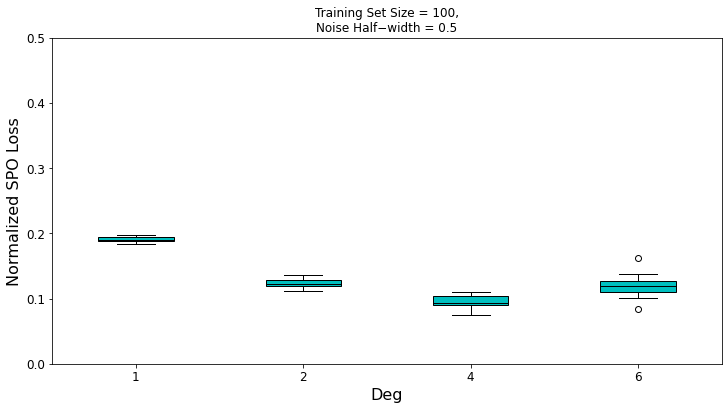

In [13]:
# draw boxplot
plt.figure(figsize=(12,6))
plt.boxplot(df2, boxprops=dict(facecolor='c', color='k'), medianprops=dict(color='k'), patch_artist=True)
plt.xlabel('Deg', fontsize=16)
plt.xticks(ticks=[1,2,3,4], labels=[1,2,4,6], fontsize=12)
plt.ylabel('Normalized SPO Loss', fontsize=16)
plt.yticks(fontsize=12)
plt.ylim(0, 0.5)
plt.title('Training Set Size = 100,\nNoise Half−width = 0.5')
plt.show()

## Training Set Size = 1000, Noise Half−width = 0 

In [14]:
# set
n = 1000 # number of data
p = 5 # size of feature
e = 0 # noise half−width
degs = [1, 2, 4, 6] # list of param deg

In [15]:
# init DataFrame
df3 = pd.DataFrame(columns = degs)

In [16]:
for i in range(8):
    row = {}
    for deg in degs:
        # generate data
        x, c = shortestpath.genData(n+1000, p, grid, deg=deg, noise_width=e, seed=i)
        # data split
        x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=i)
        # build data set
        sp_dataset_train = dataset.optDataset(sp_model, x_train, c_train)
        sp_dataset_test = dataset.optDataset(sp_model, x_test, c_test)
        # get data loader
        batch_size = 32
        sp_loader_train = DataLoader(sp_dataset_train, batch_size=batch_size, shuffle=True)
        sp_loader_test = DataLoader(sp_dataset_test, batch_size=batch_size, shuffle=False)
        # train
        learning_rate = 1e-3 * (3 ** deg + 1)
        num_epochs = 50 * deg
        lr = train(sp_loader_train, sp_model, num_epochs=num_epochs, learning_rate=learning_rate, l1_lambda=1e-3)
        # eval
        loss = unambSPO(lr, sp_model, sp_loader_test)
        print('Normalized SPO Loss: {:.2f}%'.format(loss * 100))
        row[deg] = loss
        print()
    df3 = df3.append(row, ignore_index = True)

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 447.42it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 457.01it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 50/50 [01:47<00:00,  2.14s/it]


Normalized SPO Loss: 0.17%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 476.56it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 480.20it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:35<00:00,  2.15s/it]


Normalized SPO Loss: 0.06%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 508.78it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 473.90it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [07:09<00:00,  2.15s/it]


Normalized SPO Loss: 0.71%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 498.03it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 506.56it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 300/300 [10:41<00:00,  2.14s/it]


Normalized SPO Loss: 3.61%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 451.86it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 467.24it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 50/50 [01:46<00:00,  2.14s/it]


Normalized SPO Loss: 0.23%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 472.95it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 455.14it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:53<00:00,  2.33s/it]


Normalized SPO Loss: 0.06%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 470.88it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 499.63it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [09:11<00:00,  2.76s/it]


Normalized SPO Loss: 0.62%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 406.29it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 372.68it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 300/300 [12:23<00:00,  2.48s/it]


Normalized SPO Loss: 2.57%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 469.94it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 471.17it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 50/50 [01:53<00:00,  2.26s/it]


Normalized SPO Loss: 0.12%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 488.26it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 497.54it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:54<00:00,  2.35s/it]


Normalized SPO Loss: 0.12%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 479.81it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 476.27it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [07:35<00:00,  2.28s/it]


Normalized SPO Loss: 1.33%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 481.22it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 293.80it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 300/300 [11:27<00:00,  2.29s/it]


Normalized SPO Loss: 5.08%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 424.68it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 463.82it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 50/50 [01:52<00:00,  2.25s/it]


Normalized SPO Loss: 0.08%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 486.02it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 487.23it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:48<00:00,  2.28s/it]


Normalized SPO Loss: 0.05%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 482.80it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 476.44it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [07:54<00:00,  2.37s/it]


Normalized SPO Loss: 0.92%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 470.36it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 474.75it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 300/300 [11:41<00:00,  2.34s/it]


Normalized SPO Loss: 3.56%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 467.66it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 469.71it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 50/50 [01:59<00:00,  2.40s/it]


Normalized SPO Loss: 0.15%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 413.51it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 447.69it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:01<00:00,  2.41s/it]


Normalized SPO Loss: 0.10%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 433.40it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 474.21it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [07:40<00:00,  2.30s/it]


Normalized SPO Loss: 0.87%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 455.13it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 391.22it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 300/300 [11:39<00:00,  2.33s/it]


Normalized SPO Loss: 3.05%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 483.78it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 475.46it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 50/50 [01:51<00:00,  2.23s/it]


Normalized SPO Loss: 0.23%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 488.42it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 496.42it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:42<00:00,  2.23s/it]


Normalized SPO Loss: 0.11%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 475.98it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 475.38it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [07:22<00:00,  2.21s/it]


Normalized SPO Loss: 1.25%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 476.68it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 488.89it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 300/300 [11:04<00:00,  2.21s/it]


Normalized SPO Loss: 5.06%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 500.36it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 476.27it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 50/50 [01:50<00:00,  2.21s/it]


Normalized SPO Loss: 0.15%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 427.04it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 430.50it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:42<00:00,  2.22s/it]


Normalized SPO Loss: 0.06%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 476.95it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 452.97it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [07:29<00:00,  2.25s/it]


Normalized SPO Loss: 0.63%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 481.93it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 485.01it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 300/300 [11:07<00:00,  2.23s/it]


Normalized SPO Loss: 2.48%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 490.28it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 477.64it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 50/50 [01:51<00:00,  2.24s/it]


Normalized SPO Loss: 0.13%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 485.37it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 479.10it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:41<00:00,  2.21s/it]


Normalized SPO Loss: 0.06%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 482.80it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 501.45it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [07:05<00:00,  2.13s/it]


Normalized SPO Loss: 0.95%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 502.59it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 507.16it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 300/300 [10:34<00:00,  2.11s/it]


Normalized SPO Loss: 3.68%



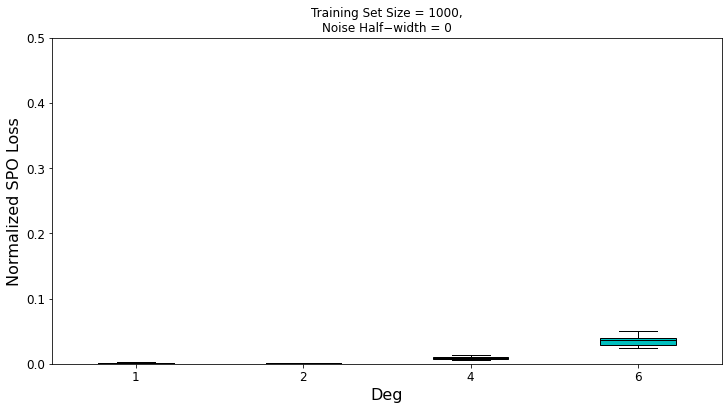

In [17]:
# draw boxplot
plt.figure(figsize=(12,6))
plt.boxplot(df3, boxprops=dict(facecolor='c', color='k'), medianprops=dict(color='k'), patch_artist=True)
plt.xlabel('Deg', fontsize=16)
plt.xticks(ticks=[1,2,3,4], labels=[1,2,4,6], fontsize=12)
plt.ylabel('Normalized SPO Loss', fontsize=16)
plt.yticks(fontsize=12)
plt.ylim(0, 0.5)
plt.title('Training Set Size = 1000,\nNoise Half−width = 0')
plt.show()

## Training Set Size = 1000, Noise Half−width = 0.5 

In [18]:
# set
n = 1000 # number of data
p = 5 # size of feature
e = 0.5 # noise half−width
degs = [1, 2, 4, 6] # list of param deg

In [19]:
# init DataFrame
df4 = pd.DataFrame(columns = degs)

In [20]:
for i in range(8):
    row = {}
    for deg in degs:
        # generate data
        x, c = shortestpath.genData(n+1000, p, grid, deg=deg, noise_width=e, seed=i)
        # data split
        x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=i)
        # build data set
        sp_dataset_train = dataset.optDataset(sp_model, x_train, c_train)
        sp_dataset_test = dataset.optDataset(sp_model, x_test, c_test)
        # get data loader
        batch_size = 32
        sp_loader_train = DataLoader(sp_dataset_train, batch_size=batch_size, shuffle=True)
        sp_loader_test = DataLoader(sp_dataset_test, batch_size=batch_size, shuffle=False)
        # train
        learning_rate = 1e-3 * (3 ** deg + 1)
        num_epochs = 50 * deg
        lr = train(sp_loader_train, sp_model, num_epochs=num_epochs, learning_rate=learning_rate, l1_lambda=1e-3)
        # eval
        loss = unambSPO(lr, sp_model, sp_loader_test)
        print('Normalized SPO Loss: {:.2f}%'.format(loss * 100))
        row[deg] = loss
        print()
    df4 = df4.append(row, ignore_index = True)

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 500.58it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 498.70it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 50/50 [01:47<00:00,  2.16s/it]


Normalized SPO Loss: 17.65%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 496.87it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 497.86it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:33<00:00,  2.14s/it]


Normalized SPO Loss: 10.89%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 512.35it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 497.36it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [07:23<00:00,  2.22s/it]


Normalized SPO Loss: 7.48%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 479.51it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 501.76it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 300/300 [11:00<00:00,  2.20s/it]


Normalized SPO Loss: 10.22%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 478.38it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 452.26it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 50/50 [01:45<00:00,  2.12s/it]


Normalized SPO Loss: 16.42%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 455.97it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 462.70it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:33<00:00,  2.13s/it]


Normalized SPO Loss: 9.31%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 498.67it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 499.27it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [07:12<00:00,  2.16s/it]


Normalized SPO Loss: 6.50%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 514.19it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 510.00it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 300/300 [10:43<00:00,  2.15s/it]


Normalized SPO Loss: 6.96%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 499.13it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 501.08it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 50/50 [01:46<00:00,  2.13s/it]


Normalized SPO Loss: 17.52%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 483.99it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 490.54it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:33<00:00,  2.14s/it]


Normalized SPO Loss: 12.16%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 454.93it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 453.29it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [07:04<00:00,  2.12s/it]


Normalized SPO Loss: 9.51%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 496.95it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 466.81it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 300/300 [10:43<00:00,  2.14s/it]


Normalized SPO Loss: 12.07%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 463.33it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 490.63it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 50/50 [01:47<00:00,  2.15s/it]


Normalized SPO Loss: 17.35%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 484.53it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 499.33it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:33<00:00,  2.13s/it]


Normalized SPO Loss: 11.08%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 517.64it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 494.98it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [07:12<00:00,  2.16s/it]


Normalized SPO Loss: 8.65%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 503.60it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 508.75it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 300/300 [10:44<00:00,  2.15s/it]


Normalized SPO Loss: 9.91%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 437.32it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 442.74it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 50/50 [01:47<00:00,  2.14s/it]


Normalized SPO Loss: 18.58%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 502.11it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 494.86it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:34<00:00,  2.15s/it]


Normalized SPO Loss: 12.13%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 500.01it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 493.64it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [07:06<00:00,  2.13s/it]


Normalized SPO Loss: 8.64%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 485.32it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 506.53it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 300/300 [10:43<00:00,  2.14s/it]


Normalized SPO Loss: 9.35%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 496.61it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 489.25it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 50/50 [01:48<00:00,  2.17s/it]


Normalized SPO Loss: 18.44%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 505.12it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 507.93it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:39<00:00,  2.19s/it]


Normalized SPO Loss: 11.41%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 488.63it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 497.30it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [07:10<00:00,  2.15s/it]


Normalized SPO Loss: 9.12%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 479.97it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 493.80it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 300/300 [10:46<00:00,  2.15s/it]


Normalized SPO Loss: 11.99%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 499.25it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 505.92it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 50/50 [01:46<00:00,  2.13s/it]


Normalized SPO Loss: 17.28%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 493.96it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 493.20it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:34<00:00,  2.14s/it]


Normalized SPO Loss: 10.77%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 504.20it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 504.87it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [07:22<00:00,  2.21s/it]


Normalized SPO Loss: 7.72%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 482.32it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 479.94it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 300/300 [11:36<00:00,  2.32s/it]


Normalized SPO Loss: 8.43%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 473.08it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 488.55it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 50/50 [01:53<00:00,  2.28s/it]


Normalized SPO Loss: 17.29%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 465.11it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 478.93it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:44<00:00,  2.24s/it]


Normalized SPO Loss: 9.67%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 487.45it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 471.05it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [07:30<00:00,  2.25s/it]


Normalized SPO Loss: 7.18%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 467.48it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 473.34it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 300/300 [11:48<00:00,  2.36s/it]


Normalized SPO Loss: 8.35%



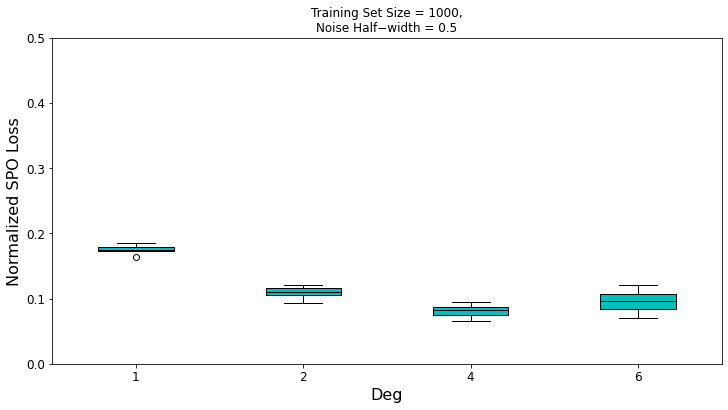

In [21]:
# draw boxplot
plt.figure(figsize=(12,6))
plt.boxplot(df4, boxprops=dict(facecolor='c', color='k'), medianprops=dict(color='k'), patch_artist=True)
plt.xlabel('Deg', fontsize=16)
plt.xticks(ticks=[1,2,3,4], labels=[1,2,4,6], fontsize=12)
plt.ylabel('Normalized SPO Loss', fontsize=16)
plt.yticks(fontsize=12)
plt.ylim(0, 0.5)
plt.title('Training Set Size = 1000,\nNoise Half−width = 0.5')
plt.show()

## Save File 

In [22]:
df1.to_csv('./res/spoplus_n100.csv', index=False)
df2.to_csv('./res/spoplus_n100_noise.csv', index=False)
df3.to_csv('./res/spoplus_n1000.csv', index=False)
df4.to_csv('./res/spoplus_n1000_noise.csv', index=False)